In [1]:
# Import Libraries and Dependencies
import matrix_games
from matrix_games.base import*
from matrix_games.generate import*

In [2]:
a = np.array(range(4,25))
print(np.max(a))

24


In [15]:
dimN = 2000
dimM = 2000
q0 = np.ones(dimN + dimM)
proximal_name = "simplex"

A = create_A("rand", (dimN,dimM))
prob = mg_problem(A, proximal_name)
F_mg, J_mg, _, prox_g_mg = prob.get_parameters()
print(prob)
print(F_mg(q0))

Matrix A: [[0.75540846 0.20299844 0.38024612 ... 0.77566541 0.83798729 0.70002506]
 [0.81868852 0.91524134 0.02806517 ... 0.93934424 0.38007988 0.27239018]
 [0.74153542 0.31107111 0.0589246  ... 0.41902385 0.94415397 0.42026309]
 ...
 [0.69118613 0.95685219 0.80792362 ... 0.42863861 0.8348412  0.71880307]
 [0.49757945 0.54658332 0.31023144 ... 0.12875851 0.27131899 0.56453572]
 [0.65888821 0.91176466 0.01023387 ... 0.83406258 0.82202628 0.07417555]]
 Matrix F: [[ 0.          0.          0.         ...  0.69118613  0.49757945
   0.65888821]
 [ 0.          0.          0.         ...  0.95685219  0.54658332
   0.91176466]
 [ 0.          0.          0.         ...  0.80792362  0.31023144
   0.01023387]
 ...
 [-0.69118613 -0.95685219 -0.80792362 ...  0.          0.
   0.        ]
 [-0.49757945 -0.54658332 -0.31023144 ...  0.          0.
   0.        ]
 [-0.65888821 -0.91176466 -0.01023387 ...  0.          0.
   0.        ]]
 Proximal Operator: [0.0005 0.0005 0.0005 ... 0.0005 0.0005 0.0005]

Adaptive Graal Implemntation

In [16]:
def adaptive_graal(J, F, prox_g, x1, numb_iter=100, phi=1.5, output=False): 
    begin = perf_counter()
    x, x_ = x1.copy(), x1.copy()
    x0 = x + np.random.randn(x.shape[0]) * 1e-9
    Fx = F(x)
    la = phi / 2 * LA.norm(x - x0) / LA.norm(Fx - F(x0))
    rho = 1. / phi + 1. / phi**2
    values = [J(x)]
    diff = [0]
    time_list = [perf_counter() - begin]
    th = 1

    for i in range(numb_iter):
        x1 = prox_g(x_ - la * Fx, la)
        Fx1 = F(x1)
        if output:
            #print("F: ", Fx1, "\n")
            print("x: ", x1, "\n")
            print("sum: ", sum(x1), "\n")
            print("x>=0: ", np.any((x1 >= 0)))
            #print("prox: ", prox_g(x_ - la * Fx, la), "\n")

        n1 = LA.norm(x1 - x)**2
        n2 = LA.norm(Fx1 - Fx)**2
        n1_div_n2 = n1/n2 if n2 != 0 else la*10

        la1 = min(rho * la, 0.25 * phi * th / la * n1_div_n2)
        x_ = ((phi - 1) * x1 + x_) / phi
        #if output:
            #print (i, la)
        th = phi * la1 / la
        x, la, Fx = x1, la1, Fx1
        #if i%50 == 0: 
            #print("x at iteration ", i , ": ", x)
        temp = values[-1]
        values.append(J(x))
        diff.append(np.absolute(temp - values[-1]))
        time_list.append(perf_counter() - begin)
    end = perf_counter()

    print("CPU time for aGRAAL:", end - begin)
    return values, x, x_, time_list, diff

Solving the VI

In [17]:
N = 20000

# starting point
q0 = np.ones(dimN + dimM)

In [18]:
show_out = False
ans1 = adaptive_graal(J_mg, F_mg, prox_g_mg, q0, numb_iter=N, phi=1.5, output=show_out)

CPU time for aGRAAL: 383.8192894


In [19]:
if show_out:
    print("J(x): " , ans1[0][-1])
    print("x: " ,ans1[1])
    print("diff: ", ans1[4])

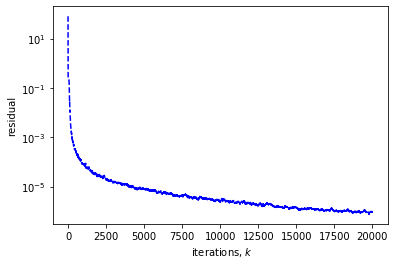

In [20]:
plt.plot(ans1[0], '--b')

plt.yscale('log')

plt.xlabel(u' iterations, $k$')
plt.ylabel(u'residual')

#plt.savefig('figures/nash.pdf', bbox_inches='tight')
plt.show()

In [10]:
print(ans1[0])

[0.09254932533120652, 0.43843037455439143, 0.1954550844905319, 0.19552681875542166, 0.1954839152370465, 0.19543623720892112, 0.1953832845710412, 0.195324476625845, 0.19525916943409444, 0.19518664907059524, 0.19510612421564982, 0.19501671800993037, 0.19491745911148628, 0.19480727189148228, 0.1946849657043329, 0.19454922316818485, 0.19439858739377947, 0.19437626600902513, 0.19479854468340552, 0.19537903914871402, 0.19565123991747047, 0.1956873453510548, 0.19568823051395717, 0.19568823051395712, 0.19568823051395706, 0.1956882305139569, 0.195688230513957, 0.19568823051395712, 0.19568823051395717, 0.195688230513957, 0.19568823051395712, 0.19568823051395717, 0.1956882305139569, 0.19568823051395706, 0.19568823051395706, 0.19568823051395695, 0.19568823051395695, 0.19568823051395717, 0.1956882305139569, 0.19568823051395712, 0.19568823051395695, 0.195688230513958, 0.19568823051395728, 0.19568823051395717, 0.19568823051395717, 0.19568823051395717, 0.19568823051395728, 0.19568823051395717, 0.19568